In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import StandardScaler

In [4]:
SEED = 42 
np.random.seed(SEED) 
torch.manual_seed(SEED)

In [5]:
class DERMNET_DATASET(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.train = train
        self.transform = transform

        self.labels_dict = {
            'Light Diseases and Disorders of Pigmentation': 0, 
            'Lupus and other Connective Tissue diseases': 1,
            'Acne and Rosacea Photos': 2,
            'Systemic Disease': 3,
            'Poison Ivy Photos and other Contact Dermatitis': 4,
            'Vascular Tumors': 5,
            'Urticaria Hives': 6,
            'Atopic Dermatitis Photos': 7,
            'Bullous Disease Photos': 8,
            'Hair Loss Photos Alopecia and other Hair Diseases': 9,
            'Tinea Ringworm Candidiasis and other Fungal Infections': 10,
            'Psoriasis pictures Lichen Planus and related diseases': 11,
            'Melanoma Skin Cancer Nevi and Moles': 12,
            'Nail Fungus and other Nail Disease': 13,
            'Scabies Lyme Disease and other Infestations and Bites': 14,
            'Eczema Photos': 15,
            'Exanthems and Drug Eruptions': 16,
            'Herpes HPV and other STDs Photos': 17,
            'Seborrheic Keratoses and other Benign Tumors': 18,
            'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 19,
            'Vasculitis Photos': 20,
            'Cellulitis Impetigo and other Bacterial Infections': 21,
            'Warts Molluscum and other Viral Infections': 22
        }

        dataset_type = 'train' if self.train else 'test'
        dataset_dir = os.path.join(root_dir, dataset_type)

        # Tạo một dictionary để lưu danh sách ảnh cho từng nhãn
        label_to_images = {label: [] for label in range(len(self.labels_dict))}

        # Duyệt qua các thư mục con và lưu đường dẫn ảnh theo nhãn tương ứng
        for class_name, class_idx in self.labels_dict.items():
            class_folder = os.path.join(dataset_dir, class_name)
            if os.path.isdir(class_folder):
                image_paths = sorted([os.path.join(class_folder, img) 
                                      for img in os.listdir(class_folder) 
                                      if img.endswith(('.png', '.jpg', '.jpeg'))])
                label_to_images[class_idx].extend(image_paths)

        # Tạo danh sách ảnh và nhãn xen kẽ
        self.image_paths = []
        self.labels = []
        for label, images in label_to_images.items():
            for img in images:
                self.image_paths.append(img)
                self.labels.append(label)

    def __len__(self):
        return len(self.labels)  # Tổng số lượng ảnh

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Mở ảnh và áp dụng transform nếu có
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)

        return image, label

    def show_image(self, idx):
        image, label = self.__getitem__(idx)
        keys = [k for k, v in self.labels_dict.items() if v == label]
        
        # Hiển thị ảnh
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Label: {keys[0]}")
        plt.show()


In [20]:
from torch.utils.data import Dataset, Subset

class CustomSubset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = Subset(dataset, indices)
        self.indices = indices
        self.labels_dict = dataset.labels_dict  # Giữ nguyên labels_dict từ dataset gốc
        self.dataset_cls = dataset  # Duy trì tham chiếu tới dataset gốc

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def get_class_counts(self):
        """Tính toán số lượng ảnh trong mỗi lớp."""
        class_counts = {class_name: 0 for class_name in self.labels_dict.keys()}
        for idx in self.indices:
            label = self.dataset_cls.labels[idx]
            class_name = [k for k, v in self.labels_dict.items() if v == label][0]
            class_counts[class_name] += 1
        return class_counts

    def show_image(self, idx):
        """Hiển thị ảnh."""
        actual_idx = self.indices[idx]
        self.dataset_cls.show_image(actual_idx)

In [6]:
import torchvision.transforms as transforms 
# Định nghĩa các bước tiền xử lý 
transform = transforms.Compose([ transforms.Resize((128, 128)),   
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [7]:
train_dataset = DERMNET_DATASET('/kaggle/input/dermnet', train=True, transform=transform)
test_dataset = DERMNET_DATASET('/kaggle/input/dermnet', train=False, transform=transform)

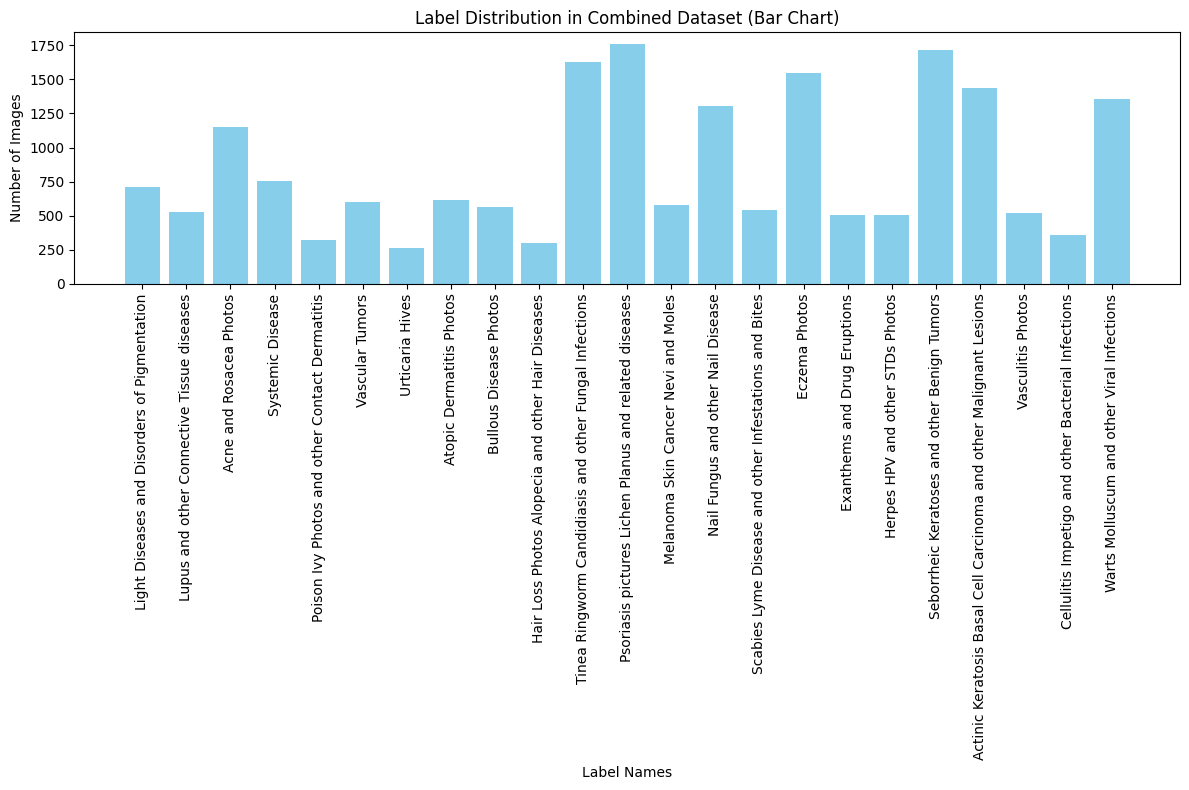

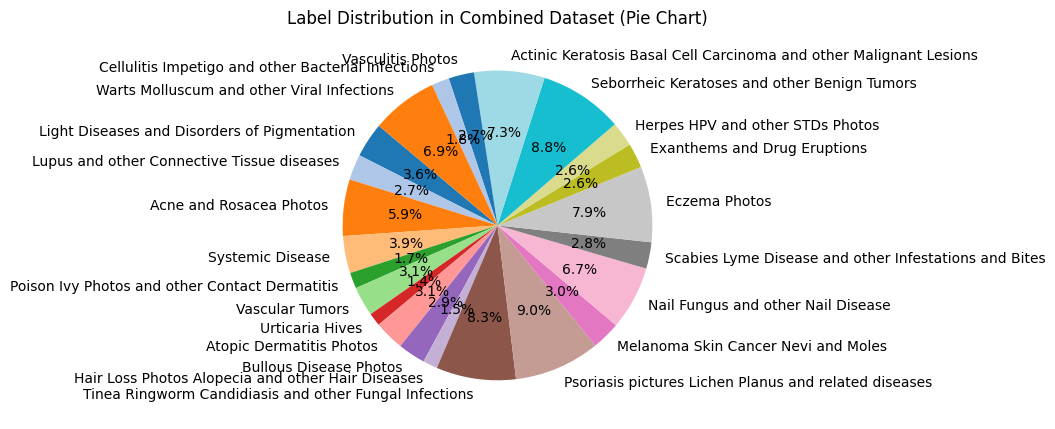

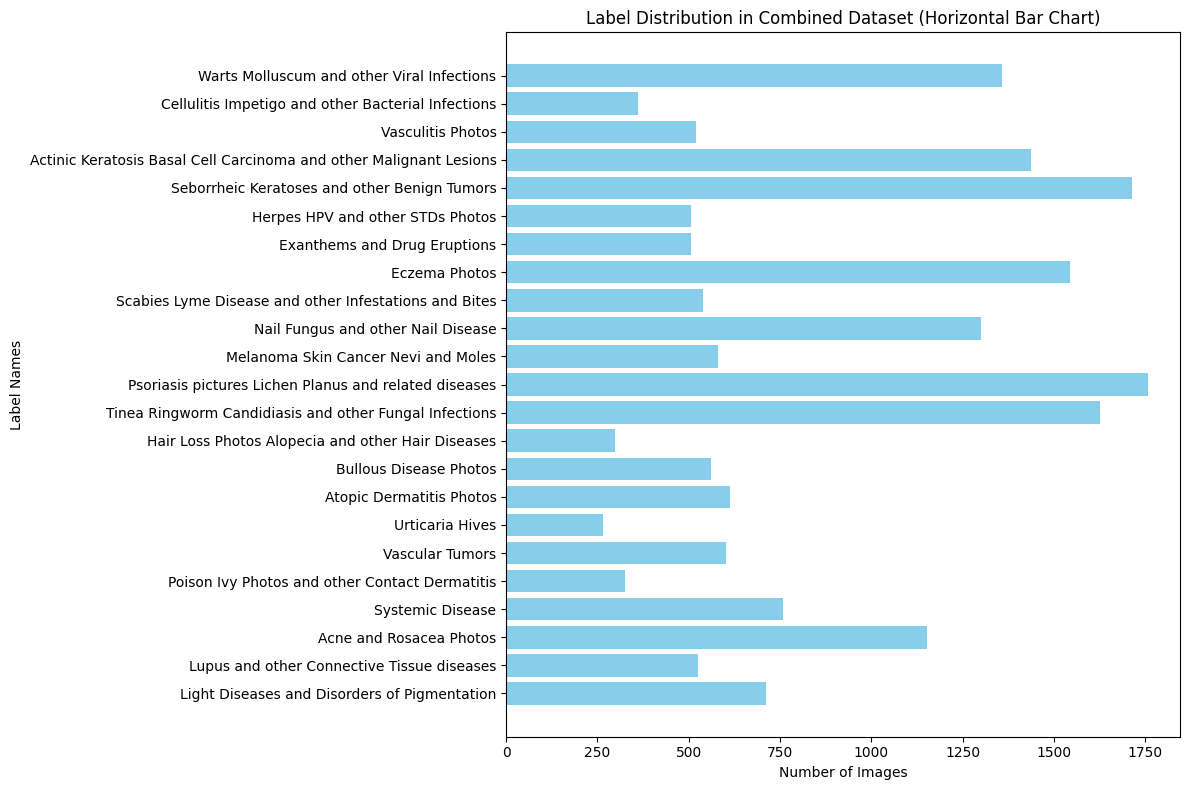

In [9]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Kết hợp nhãn từ train và test dataset
combined_labels = train_dataset.labels + test_dataset.labels

# Đếm số lượng mỗi nhãn
label_counts = Counter(combined_labels)

# Lấy danh sách nhãn và số lượng
labels, counts = zip(*label_counts.items())

# Tạo nhãn tương ứng (tên class)
label_names = [key for key, value in train_dataset.labels_dict.items() if value in labels]

# Sắp xếp theo nhãn
sorted_indices = np.argsort(labels)
sorted_labels = [labels[i] for i in sorted_indices]
sorted_counts = [counts[i] for i in sorted_indices]
sorted_names = [label_names[i] for i in sorted_indices]

# Vẽ biểu đồ cột
plt.figure(figsize=(12, 8))
plt.bar(sorted_names, sorted_counts, color="skyblue")
plt.xlabel("Label Names")
plt.ylabel("Number of Images")
plt.title("Label Distribution in Combined Dataset (Bar Chart)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("bar_chart.png")  # Lưu biểu đồ cột
plt.show()

# Vẽ biểu đồ tròn
plt.figure(figsize=(10, 10))
plt.pie(sorted_counts, labels=sorted_names, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title("Label Distribution in Combined Dataset (Pie Chart)")
plt.tight_layout()
plt.savefig("pie_chart.png")  # Lưu biểu đồ tròn
plt.show()

# Vẽ biểu đồ thanh ngang
plt.figure(figsize=(12, 8))
plt.barh(sorted_names, sorted_counts, color="skyblue")
plt.xlabel("Number of Images")
plt.ylabel("Label Names")
plt.title("Label Distribution in Combined Dataset (Horizontal Bar Chart)")
plt.tight_layout()
plt.savefig("horizontal_bar_chart.png")  # Lưu biểu đồ thanh ngang
plt.show()


In [23]:
batch_size = 128
labels = train_dataset.labels

# Chia dữ liệu train thành train và validation theo tỉ lệ 8/2
train_indices, val_indices = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=SEED, stratify=labels)
train_subset = CustomSubset(train_dataset, train_indices)
val_subset = CustomSubset(train_dataset, val_indices)

# Sử dụng WeightedRandomSampler để cân bằng nhãn cho tập train
train_labels = [train_dataset.labels[i] for i in train_indices]
class_sample_counts = np.bincount(train_labels)
weights = 1. / class_sample_counts[train_labels]
train_sampler = WeightedRandomSampler(weights, len(weights))

# Tạo DataLoader cho train và val
train_dataloader = DataLoader(train_subset, batch_size=batch_size, sampler=train_sampler)
val_dataloader = DataLoader(val_subset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# In ra số lượng ảnh trong mỗi DataLoader
print(f'Train DataLoader: {len(train_dataloader.dataset)} images')
print(f'Validation DataLoader: {len(val_dataloader.dataset)} images')
print(f'Test DataLoader: {len(test_dataloader.dataset)} images')


Train DataLoader: 12445 images
Validation DataLoader: 3112 images
Test DataLoader: 4002 images


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
from torchvision.models import convnext_tiny, densenet121, mobilenet_v2, resnet50
import timm

In [26]:
class ConvNeXtTinyModel(nn.Module):
    def __init__(self, num_classes=23, pretrained=True, freeze_backbone=False):
        super(ConvNeXtTinyModel, self).__init__()
        
        # Load pre-trained ConvNeXt Tiny model
        self.model = convnext_tiny(pretrained=pretrained)
        
        # Optionally freeze backbone layers
        if freeze_backbone:
            for param in self.model.features.parameters():
                param.requires_grad = False
        
        # Replace the classifier layer (fully connected layer) to match the number of classes
        in_features = self.model.classifier[2].in_features
        self.model.classifier[2] = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.model(x)


class DenseNet121(nn.Module):
    def __init__(self, num_classes=10, pretrained=True, frozen=False):
        super(DenseNet121, self).__init__()
        self.model = densenet121(pretrained=pretrained)
        
        if frozen:
            for param in self.model.features.parameters():  # Freeze chỉ các lớp feature extractor
                param.requires_grad = False
        
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        # Truyền input qua mô hình DenseNet121
        return self.model(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10, frozen=False):
        super(MobileNetV2, self).__init__()
        self.model = mobilenet_v2(pretrained=True)
        if frozen:
            for param in self.model.parameters():
                param.requires_grad = False
        num_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        return self.model(x)

class EfficientNetV2(nn.Module):
    def __init__(self, num_classes=10, frozen=False):
        super(EfficientNetV2, self).__init__()
        self.model = timm.create_model('efficientnetv2_rw_t', pretrained=True)
        if frozen:
            for param in self.model.parameters():
                param.requires_grad = False
            for param in self.model.classifier.parameters():
                param.requires_grad = True
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        return self.model(x)

class ResNet50(nn.Module):
    def __init__(self, num_classes=10, frozen=False):
        super(ResNet50, self).__init__()
        self.model = resnet50(pretrained=True)
        if frozen:
            for param in self.model.parameters():
                param.requires_grad = False
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        return self.model(x)

class ViTClassifier128(nn.Module):
    def __init__(self, num_classes=23, pretrained=True, img_size=128, freeze_backbone=False):
        super(ViTClassifier128, self).__init__()
        
        # Tải mô hình ViT với kích thước ảnh 128x128
        self.vit = timm.create_model(
            'vit_base_patch16_224',
            pretrained=pretrained,
            img_size=img_size
        )
        
        # Freeze backbone nếu cần
        if freeze_backbone:
            for param in self.vit.parameters():
                param.requires_grad = False

        # Lấy số lượng đầu ra từ lớp head
        in_features = self.vit.head.in_features
        
        # Thay thế lớp head bằng lớp phân loại tùy chỉnh
        self.vit.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

In [27]:
# Load toàn bộ mô hình
convnext_frozen = torch.load('/kaggle/input/basemodels/other/default/1/best_model/best_convnext_frozen.path').to(device)
convnext_unfrozen = torch.load('/kaggle/input/basemodels/other/default/1/best_model/best_convnext_unfrozen.path').to(device)
densenet_frozen = torch.load('/kaggle/input/basemodels/other/default/1/best_model/best_model_densenet_frozen.pth').to(device)
densenet_unfrozen = torch.load('/kaggle/input/basemodels/other/default/1/best_model/best_model_densenet_unfrozen.pth').to(device)
mobilenet_frozen = torch.load('/kaggle/input/basemodels/other/default/1/best_model/best_model_mobile.pth').to(device)
mobilenet_unfrozen = torch.load('/kaggle/input/basemodels/other/default/1/best_model/best_model_unfrozen_mobile.pth').to(device)
swin_frozen = torch.load('/kaggle/input/basemodels/other/default/1/best_model/best_swin_frozen.path').to(device)
efficientnet_frozen = torch.load('/kaggle/input/basemodels/other/default/1/best_model/best_model_efficient_frozen.path').to(device)
efficientnet_unfrozen = torch.load('/kaggle/input/basemodels/other/default/1/best_model/best_model_efficient_unfrozen.path').to(device)
resnet50_frozen = torch.load('/kaggle/input/basemodels/other/default/1/best_model/resnet50frozen.pth').to(device)
resnet50_unfrozen = torch.load('/kaggle/input/basemodels/other/default/1/best_model/resnet50unfrozen.pth').to(device)

/tmp/ipykernel_23/2724584629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  convnext_frozen = torch.load('/kaggle/input/basemodels/other/default/1/best_model/best_convn

In [28]:
def precompute_model_outputs(base_models, loader, device):
    """
    Lưu trước đầu ra của từng mô hình cơ sở.
    """
    model_outputs = {}
    labels_list = []

    for images, labels in tqdm(loader, desc="Extracting Outputs"):
        images = images.to(device)
        batch_outputs = []

        for i, model in enumerate(base_models):
            model.eval()
            with torch.no_grad():
                output = model(images).cpu().numpy()
                if i not in model_outputs:
                    model_outputs[i] = []
                model_outputs[i].append(output)
        
        labels_list.append(labels.cpu().numpy())

    # Gộp toàn bộ batch lại
    for i in model_outputs:
        model_outputs[i] = np.vstack(model_outputs[i])
    labels = np.hstack(labels_list)

    return model_outputs, labels


# Danh sách các mô hình
base_models = [
    convnext_frozen, convnext_unfrozen, densenet_frozen, densenet_unfrozen,
    mobilenet_frozen, mobilenet_unfrozen, efficientnet_frozen,
    efficientnet_unfrozen, resnet50_frozen, resnet50_unfrozen, swin_frozen
]
base_models_string = [
    'convnext_frozen', 'convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen',
    'mobilenet_frozen', 'mobilenet_unfrozen', 'efficientnet_frozen',
    'efficientnet_unfrozen', 'resnet50_frozen', 'resnet50_unfrozen', 'swin_frozen'
]

In [29]:
class MetaLearner(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MetaLearner, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [30]:
def fitness_function(chromosome, train_outputs_dict, train_labels, val_outputs_dict, val_labels, device, cache):
    """
    Tính fitness cho một tổ hợp mô hình (chromosome) bằng cách sử dụng trung bình cộng đơn giản của các đầu ra được chọn.
    """
    chromosome_key = tuple(chromosome.tolist())
    if chromosome_key in cache:
        return cache[chromosome_key]

    # Lấy các đầu ra được chọn từ dictionary
    selected_train_outputs = [train_outputs_dict[i] for i in range(len(chromosome)) if chromosome[i] == 1]
    selected_val_outputs = [val_outputs_dict[i] for i in range(len(chromosome)) if chromosome[i] == 1]

    if not selected_train_outputs:  # Không có mô hình nào được chọn
        cache[chromosome_key] = 0
        return 0

    # Tính trung bình cộng đơn giản
    avg_train_outputs = np.mean(selected_train_outputs, axis=0)
    avg_val_outputs = np.mean(selected_val_outputs, axis=0)

    # Chuyển nhãn thành torch.Tensor
    val_labels_tensor = torch.tensor(val_labels, dtype=torch.long, device=device)

    # Tính accuracy trên validation set
    correct = 0
    total = 0
    with torch.no_grad():
        outputs = torch.tensor(avg_val_outputs).to(device)
        _, preds = torch.max(outputs, 1)
        correct = (preds.cpu().numpy() == val_labels).sum()
        total = len(val_labels)

    val_accuracy = correct / total
    cache[chromosome_key] = val_accuracy
    return val_accuracy
    
def genetic_algorithm(base_models, base_models_string,train_outputs_dict, train_labels,val_outputs_dict, val_labels, device, num_generations=10, population_size=20):
    """
    Genetic Algorithm để tìm tổ hợp mô hình tốt nhất.
    """
    # Lưu trước đầu ra của mô hình


    num_models = len(base_models)
    def initialize_population_fixed_selection(population_size, num_models, k):
        population = np.zeros((population_size, num_models), dtype=int)
        for i in range(population_size):
            selected_indices = np.random.choice(num_models, k, replace=False)
            population[i, selected_indices] = 1
        return population

    # Sử dụng
    population = initialize_population_fixed_selection(population_size, num_models, k=2)

    best_chromosome = None
    best_fitness = 0
    cache = {}

    for generation in tqdm(range(num_generations), desc="Generations"):
        fitness_scores = []

        for chromosome in tqdm(population, desc=f"Evaluating Population (Generation {generation})", leave=False):
            fitness = fitness_function(
                chromosome, train_outputs_dict, train_labels, val_outputs_dict, val_labels, device, cache
            )
            fitness_scores.append(fitness)

        gen_best_fitness = max(fitness_scores)
        gen_best_chromosome = population[np.argmax(fitness_scores)]

        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_chromosome = gen_best_chromosome

        selected_models = [base_models_string[i] for i in range(num_models) if gen_best_chromosome[i] == 1]
        print(f"Generation {generation}, Best fitness: {gen_best_fitness:.4f}, Models: {selected_models}")

        # Chọn bố mẹ và tạo thế hệ mới
        parents = population[np.argsort(fitness_scores)[-10:], :]
        next_generation = []
        for _ in range(population_size // 2):
            parent1, parent2 = random.choices(parents, k=2)
            crossover_point = random.randint(1, num_models - 1)
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))

            mutation_rate = 0.1
            if random.random() < mutation_rate:
                child1[random.randint(0, num_models - 1)] ^= 1
            if random.random() < mutation_rate:
                child2[random.randint(0, num_models - 1)] ^= 1

            next_generation.append(child1)
            next_generation.append(child2)

        population = np.array(next_generation)

    print(f"Best chromosome: {best_chromosome}")
    print(f"Best fitness: {best_fitness:.4f}")
    return best_chromosome, best_fitness, len(cache)


In [31]:
train_outputs_dict, train_labels = precompute_model_outputs(base_models, train_dataloader, device)
val_outputs_dict, val_labels = precompute_model_outputs(base_models, val_dataloader, device)
test_outputs_dict, test_labels = precompute_model_outputs(base_models, test_dataloader, device)

Extracting Outputs: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it]


In [32]:
import random
best_chromosome, best_fitness, length = genetic_algorithm(
    base_models_string=base_models_string,
    base_models=base_models,
    device=device,
    num_generations=100,
    population_size=20,
    train_outputs_dict = train_outputs_dict , 
    train_labels = train_labels,
    val_outputs_dict = val_outputs_dict, 
    val_labels = val_labels
)

Evaluating Population (Generation 0):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                            

Generation 0, Best fitness: 0.5884, Models: ['convnext_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 1):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                            

Generation 1, Best fitness: 0.5868, Models: ['convnext_unfrozen', 'densenet_frozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 2):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                            

Generation 2, Best fitness: 0.5816, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'mobilenet_unfrozen']



Evaluating Population (Generation 3):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                            

Generation 3, Best fitness: 0.5816, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'mobilenet_unfrozen']



Generations:   5%|▌         | 5/100 [00:00<00:02, 43.75it/s]                

Generation 4, Best fitness: 0.5816, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'mobilenet_unfrozen']



Evaluating Population (Generation 5):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                            

Generation 5, Best fitness: 0.5816, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'mobilenet_unfrozen']



Evaluating Population (Generation 6):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                            

Generation 6, Best fitness: 0.5816, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'mobilenet_unfrozen']



Evaluating Population (Generation 7):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                            

Generation 7, Best fitness: 0.5861, Models: ['convnext_frozen', 'convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'mobilenet_unfrozen']



Evaluating Population (Generation 8):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                            

Generation 8, Best fitness: 0.6035, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'mobilenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 9):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                            

Generation 9, Best fitness: 0.6035, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'mobilenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 10):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 10, Best fitness: 0.6035, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'mobilenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 11):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 11, Best fitness: 0.6035, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'mobilenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 12):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 12, Best fitness: 0.6044, Models: ['convnext_frozen', 'convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 13):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 13, Best fitness: 0.6044, Models: ['convnext_frozen', 'convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 14):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 14, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Generations:  16%|█▌        | 16/100 [00:00<00:01, 76.62it/s]                

Generation 15, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 16):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 16, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 17):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 17, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 18):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 18, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 19):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 19, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 20):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 20, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 21):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 21, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 22):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 22, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 23):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 23, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 24):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 24, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 25):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 25, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 26):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 26, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 27):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 27, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 28):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 28, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 29):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 29, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 30):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 30, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']


Evaluating Population (Generation 31):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 31, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 32):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 32, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 33):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 33, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 34):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 34, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 35):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 35, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 36):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 36, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 37):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 37, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 38):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 38, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 39):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 39, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 40):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 40, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 41):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 41, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 42):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 42, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 43):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 43, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 44):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 44, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 45):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 45, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 46):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 46, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 47):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 47, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Generations:  49%|████▉     | 49/100 [00:00<00:00, 131.65it/s]               

Generation 48, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 49):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 49, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 50):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 50, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 51):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 51, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 52):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 52, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 53):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 53, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 54):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 54, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 55):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 55, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 56):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 56, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 57):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 57, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 58):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 58, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 59):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 59, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 60):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 60, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 61):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 61, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 62):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 62, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 63):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 63, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 64):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 64, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Generations:  66%|██████▌   | 66/100 [00:00<00:00, 141.97it/s]               

Generation 65, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 66):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 66, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 67):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 67, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 68):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 68, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 69):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 69, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 70):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 70, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 71):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 71, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 72):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 72, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 73):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 73, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 74):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 74, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 75):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 75, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 76):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 76, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 77):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 77, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 78):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 78, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 79):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 79, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 80):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 80, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Generations:  82%|████████▏ | 82/100 [00:00<00:00, 145.76it/s]               

Generation 81, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 82):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 82, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 83):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 83, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 84):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 84, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 85):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 85, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 86):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 86, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 87):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 87, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 88):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 88, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 89):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 89, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 90):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 90, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 91):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 91, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 92):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 92, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 93):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 93, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 94):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 94, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 95):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 95, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 96):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 96, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Generations:  98%|█████████▊| 98/100 [00:00<00:00, 149.31it/s]               

Generation 97, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 98):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 98, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']



Evaluating Population (Generation 99):   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             

Generation 99, Best fitness: 0.6057, Models: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']


Generations: 100%|██████████| 100/100 [00:00<00:00, 131.49it/s]


Best chromosome: [0 1 1 1 0 0 0 1 0 0 0]
Best fitness: 0.6057


In [33]:
def train_and_evaluate_final_model(best_chromosome, base_models, base_models_string, train_outputs_dict, train_labels,val_outputs_dict, val_labels ,test_outputs_dict, test_labels,device, save_folder="saved_models"):
    """
    Sử dụng tổ hợp mô hình tốt nhất để đánh giá trên tập test với độ chính xác Top-1 và Top-5,
    sử dụng trung bình cộng đơn giản của các đầu ra được chọn.
    """
    # Lưu trước đầu ra từ các mô hình được chọn
    selected_models = [base_models[i] for i in range(len(best_chromosome)) if best_chromosome[i] == 1]
    selected_model_names = [base_models_string[i] for i in range(len(best_chromosome)) if best_chromosome[i] == 1]

    print(f"Selected models for final evaluation: {selected_model_names}")

    # Lấy các đầu ra từ dictionary cho các mô hình được chọn
    selected_test_outputs = [test_outputs_dict[i] for i in range(len(best_chromosome)) if best_chromosome[i] == 1]

    if not selected_test_outputs:
        print("No models selected for evaluation.")
        return 0, 0

    # Tính trung bình cộng đơn giản trên các đầu ra được chọn
    avg_test_outputs = np.mean(selected_test_outputs, axis=0)

    # Chuyển nhãn test thành torch.Tensor
    test_labels_tensor = torch.tensor(test_labels, dtype=torch.long, device=device)

    # Đánh giá trên tập test
    correct_top1 = 0
    correct_top5 = 0
    total = len(test_labels)

    with torch.no_grad():
        outputs = torch.tensor(avg_test_outputs).to(device)
        _, preds_top1 = torch.max(outputs, 1)
        _, preds_top5 = torch.topk(outputs, 5, dim=1)

        correct_top1 = (preds_top1.cpu().numpy() == test_labels).sum()
        correct_top5 = sum([test_labels[i] in preds_top5[i].cpu().numpy() for i in range(total)])

    test_accuracy_top1 = correct_top1 / total
    test_accuracy_top5 = correct_top5 / total
    print(f"Test accuracy (Top-1): {test_accuracy_top1:.4f}")
    print(f"Test accuracy (Top-5): {test_accuracy_top5:.4f}")

    return test_accuracy_top1, test_accuracy_top5
    

In [34]:
train_and_evaluate_final_model(best_chromosome, base_models, base_models_string, train_outputs_dict, train_labels,val_outputs_dict, val_labels ,test_outputs_dict, test_labels, device)

Selected models for final evaluation: ['convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'efficientnet_unfrozen']
Test accuracy (Top-1): 0.5995
Test accuracy (Top-5): 0.8758


(0.5994502748625687, 0.8758120939530235)

In [35]:
all = [1,1,1,1,1,1,1,1,1,1,1]
train_and_evaluate_final_model(all, base_models, base_models_string, train_outputs_dict, train_labels,val_outputs_dict, val_labels ,test_outputs_dict, test_labels, device)

Selected models for final evaluation: ['convnext_frozen', 'convnext_unfrozen', 'densenet_frozen', 'densenet_unfrozen', 'mobilenet_frozen', 'mobilenet_unfrozen', 'efficientnet_frozen', 'efficientnet_unfrozen', 'resnet50_frozen', 'resnet50_unfrozen', 'swin_frozen']
Test accuracy (Top-1): 0.5910
Test accuracy (Top-5): 0.8788


(0.5909545227386307, 0.8788105947026487)